#### Variational Autoencoder for Molecule generation

There are two main approaches for molecule generation
- Automatic chemical design using data-driven continuous representation: This approach explores open-ended spaces of chemical compounds. The method is described in https://arxiv.org/abs/1610.02415.
- Variational Autoencoder for molecule generation in drug discovery (MolGAN): This is a more implicit model for small molecule design, detailed in https://arxiv.org/abs/1805.11973

#### Data-Driven Continuous Representation Approach

In the first approach, an encoder converts a string representation of a molecule into a continuous vector. A decoder then converts this vector back into a discrete molecule representation (string). A predictor estimates properties from the latent vector of the molecule. The continuous representation allows for gradient optimization and search for functional compounds.

Process:

A discrete molecule representation (SMILES string) is converted into a vector for use in the latent space. Given a point in the latent space, the decoder produces a SMILES string. A multilayer perceptron estimates the target properties associated with each molecule. Gradient optimization is performed continuously in the latent space to find new latent representations that match specific desired properties. The new latent representations are then decoded into SMILES strings.

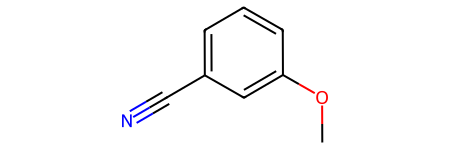

In [ ]:
'''
graph LR
    A[SMILES] --> B(Encoder);
    B --> C[Latent Space];
    C --> D(Decoder);
    D --> E[SMILES];
    B --> F{VAE jointly trained on properties};
    D --> F;
    F --> C;

+--------+   -->   +---------+ ---->   +-------------------------------------+
| SMILES | ---->   | Encoder | ---->   | VAE (Jointly Trained on Properties) |
+--------+         +---------+         +-------------------------------------+

            --->  +-------------+ --->  +---------+   --->  +---------------+
            --->  | Latent Space| --->  | Decoder |   --->  | SMILES (Output)|
                  +-------------+       +---------+         +---------------+

Smiles representation
We traverse themolecular graph in DFS manner with smallest labels at each point
'''
Chem.MolFromSmiles('COc(c1)cccc1C#N')

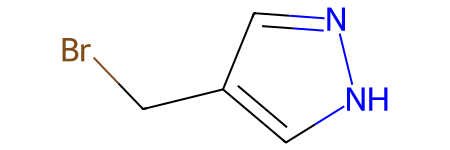

In [ ]:
''' Representations Learning
Molecule in graph representation -> SMILES        SMILES Input
                                                        |
One hot encoding              - vectors input     Encoder NN (RNN)
    Br C c 1 c [ n H ] n c 1                            |
Br  1. 0 0 0 0 0 0 0 0 0 0 0                      Latent Space
C   0. 1 0 0 0 0 0 0 0 0 0 0                      - Continuous molecu;ar --> y
H   0. 0 0 0 0 0 0 1 0 0 0 0                      representation          prop.
c   0. 0 1 0 1 0 0 0 0 0 1 0                            |                 pred
n   ....      ....      ....                      Decoder NN
Seq2Seq model with RNN to encode SMILES                 |
VAE generates the new SMILES                      SMILES Output
property prediction network added                       |
'''
Chem.MolFromSmiles('BrCc1c[nH]nc1')

Key Components and Data

RDKit: This machine learning toolkit transforms SMILES strings into molecules.

SMILES: Used for string representation and as a data structure. Encoding serves as a data structure for molecules, facilitating search and algorithms for visualization or property computation.

Datasets: QM9 and ZINC datasets are used. They come in SMILES format and include properties used for property analysis and drug-likeness assessment.

Encoder: Utilizes a graph data structure and processes the graph's adjacency matrix and feature matrix via graph convolution layers for non-linearly transformed neighborhood aggregations.

Decoder: Takes the latent space representation as input to predict the graph adjacency matrix and feature matrix of the corresponding molecules.

Research and Implementation adapted from moleculeAI generation with VAE
- Links:
[Keras WGAN Graphs](https://keras.io/examples/generative/wgan-graphs/), [VAE for Molecule Discovery](https://github.com/DrKenReid/VAE-for-Molecule-Discovery), [Molecule Generation](https://github.com/MolecularAI)

In [ ]:
''' Installations
PyTorch and Rdkit are industry standards for use in molecular data '''

In [ ]:
!pip install -U torch rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from typing import Tuple, List, Dict

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
from __future__ import print_function

In [ ]:
''' QM9 dataset as the standard benchmark '''
!wget "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"

--2025-03-03 20:28:27--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.193.178, 3.5.161.183, 3.5.160.24, ...
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.193.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29856825 (28M) [text/csv]
Saving to: ‘qm9.csv.1’

qm9.csv.1           100%[===================>]  28.47M  22.9MB/s    in 1.2s    

2025-03-03 20:28:29 (22.9 MB/s) - ‘qm9.csv.1’ saved [29856825/29856825]



In [ ]:
df = pd.read_csv('qm9.csv')
smiles_list = df['smiles'].tolist()
print(f"Extracted {len(smiles_list)} SMILES strings from the dataset")

Extracted 133885 SMILES strings from the dataset


In [ ]:
print(smiles_list[:15])

['C', 'N', 'O', 'C#C', 'C#N', 'C=O', 'CC', 'CO', 'CC#C', 'CC#N', 'CC=O', 'C(=O)N', 'CCC', 'CCO', 'COC']


In [ ]:
smiles_list[20:25]

['CC(C)C', 'CC(C)O', 'C#CC#C', 'C#CC#N', 'C(#N)C#N']

In [ ]:
''' create the vocabulary for SMILES strings to process them as tokens '''
from typing import List, Dict
def create_vocabulary(smiles_list: List[str]) -> Dict[str, int]:
    vocab = {'<': 0, '>': 1}  # Start and end tokens
    for smiles in smiles_list:
        for char in smiles:
            if char not in vocab:
              vocab[char] = len(vocab)
    return vocab
vocab = create_vocabulary(smiles_list)

In [ ]:
''' one-hot encoded tensors
for index, char in enumerate(smiles_list[:10]):
  encoded = torch.zeros(100, len(vocab))
  encoded[index, vocab.get(char,0)] = 1
encoded
'''

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
''' create custom dataset
'<', and '>' start and end tokens added to the encoding + one-hot-encoding '''
class SMILESDataset(Dataset):
  def __init__(self, smiles_list, vocab, max_length: int = 100):
    self.smiles_list = smiles_list
    self.vocab = vocab
    self.vocab_size = len(vocab)
    self.max_length = max_length

  def __len__(self) -> int:
    return len(self.smiles_list)

  def __getitem__(self, idx: int) -> torch.Tensor:
    smiles = '<' + self.smiles_list[idx] + '>'
    encoded = torch.zeros(self.max_length, self.vocab_size)
    for i, c in enumerate(smiles[:self.max_length]):
      encoded[i, self.vocab.get(c, 0)] = 1
    return encoded

def custom_collate(batch):
    return torch.stack(batch)

batch_size = 128
dataset = SMILESDataset(smiles_list, vocab, max_length=100)
dataloader_qm9 = DataLoader(
    dataset, batch_size=batch_size, shuffle=True,
    collate_fn=custom_collate,
    num_workers=2, pin_memory=True)

In [ ]:
''' model architecture
VAE: Encoder- Latent Space - Decoder
use GRU layers for the encoder and decoder

Smiles vocab -> hidden_dim GRUs -> latent_dim GRUs -> reconstruction
fc_mu fully connected layer for mean of latent space
fc_logvar fully connected layer for log variance of latent space
fc_output fully connected layer for output of decoder (output probabilities)
'''
class VAE(nn.Module):
  def __init__(self, vocab_size, hidden_dim, latent_dim):
    super(VAE, self).__init__()
    self.vocab_size = vocab_size
    self.hidden_dim = hidden_dim
    self.latent_dim = latent_dim
    self.encoder = nn.GRU(vocab_size, hidden_dim, batch_first=True)
    self.fc_mu = nn.Linear(hidden_dim, latent_dim)
    self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
    self.decoder = nn.GRU(vocab_size + latent_dim, hidden_dim, batch_first=True)
    self.fc_output = nn.Linear(hidden_dim, vocab_size)

  def encode(self, x):
    _, h = self.encoder(x)
    h = h.squeeze(0)
    mu = self.fc_mu(h)
    logvar = self.fc_logvar(h)
    return mu, logvar

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z, max_length):
    batch_size = z.size(0)
    h = torch.zeros(1, batch_size, self.hidden_dim).to(z.device)
    x = torch.zeros(batch_size, 1, self.vocab_size).to(z.device)
    outputs = []
    for _ in range(max_length):
      z_input = z.unsqueeze(1).repeat(1, 1, 1)
      decoder_input = torch.cat([x, z_input], dim=2)
      output, h = self.decoder(decoder_input, h)
      output = self.fc_output(output)
      outputs.append(output)
      x = torch.softmax(output, dim=1)
    return torch.cat(outputs, dim=1)

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    output = self.decode(z, x.size(1))
    return output, mu, logvar

In [ ]:
''' train the model with a reconstruction loss crossentropy and KL divergence '''
def loss_function(recon_x, x, mu, logvar):
    binaryCrossEntropy = nn.functional.binary_cross_entropy_with_logits(
                                          recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return binaryCrossEntropy + 0.1 * KLD

''' Model initialization '''
vocab_size = len(vocab)
hidden_dim = 256
latent_dim = 64
model = VAE(vocab_size, hidden_dim, latent_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode='min', factor=0.5, patience=5)
use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

<ipython-input-28-ec3eecfac4e5>:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [ ]:
''' Training loop '''
def train(model, num_epochs, dataloader):
  for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
      batch = batch.to(device, non_blocking=True)
      optimizer.zero_grad(set_to_none=True)
      # Use autocast only if CUDA is available
      with torch.cuda.amp.autocast(enabled=use_amp):
        recon_batch, mu, logvar = model(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
      # Backward pass and optimization with gradient scaling if CUDA is available
      if use_amp:
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
      else:
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

      avg_loss = total_loss / len(dataloader.dataset)
      #print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')
      # update learning rate
      scheduler.step(avg_loss)
      # current learning rate
      current_lr = optimizer.param_groups[0]['lr']
      #print(f'Current learning rate: {current_lr:.6f}')

  print("Training complete!")
train(model, num_epochs =20, dataloader=dataloader_qm9)

qm9.csv  qm9.csv.1  sample_data/


In [ ]:
''' set the model in evaluation mode '''
model.eval()
''' invert vocabulary for decoding '''
invert_vocab = {value: key for key, value in vocab.items()}
''' generate new molecules using decoder '''
generated_smiles = []
''' disable gradient computation '''
with torch.no_grad():
  for i in range(10):
    z = torch.randn(1, model.latent_dim).to(device)
    x = torch.zeros(1, 1,model.vocab_size).to(device)
    x[0, 0, vocab['<']] = 1
    h = torch.zeros(1, 1, model.hidden_dim).to(device)
    smiles = ''
    for _ in range(100):
      z_input = z.unsqueeze(1) #.repeat(1, 1, 1)
      decoder_input = torch.cat([x, z_input], dim=2)
      output, h = model.decoder(decoder_input, h)
      output = model.fc_output(output)
      probs = torch.softmax(output.squeeze(0), dim=-1)
      next_char = torch.multinomial(probs, 1).item()
      if invert_vocab[next_char] == '>':
        break
      smiles += invert_vocab[next_char]
      x = torch.zeros(1, 1, model.vocab_size).to(device)
      x[0, 0, next_char] = 1
    generated_smiles.append(smiles)
#len(generated_smiles)

In [ ]:
for index, smiles in enumerate(generated_smiles):
  print(f"{index+1}: {smiles}")

1: #1[cn2]<=NO<(FN[)+3([)4H+#<#5H4[H2nN]+<#FN3NO=1)5[2c=F1<C3<HNNO2cN2oo4N-F)++]=-<H#+ON)<nCO]++N<4(
2: C)N=4]n[131=1341([H3O#H#)
3: nc4##oO3=3HncC]O
4: O)FC2(n
5: HN<=F[(5H[))+on)c(1([
6: [5]N-N+)N5(NC+=n4
7: 43n[FnnFOOH-c3H]<C)[5C<1]NcC11+NN3F513(OO#c-HC3cCnO(O#3Cn])-<
8: C[C2#([
9: n5(15([=5))1
10: c-)+n


In [ ]:
analysis = analyze_molecules(generated_smiles)

In [ ]:
analysis['valid'], analysis['invalid'], analysis['unique'], analysis['corrected'], \
analysis['properties']

Original implementation VAE

The train the NN to predict properties in Latent Space

link: https://pubs.acs.org/doi/10.1021/acscentsci.7b00572

In [ ]:
class MolecularVAE(nn.Module):
  def __init__(self):
    super().__init__()

    # encoder related blocks
    self.conv_1 = nn.Conv1d(120, 9, kernel_size=9)
    self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
    self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)
    self.linear_0 = nn.Linear(70, 435)
    self.linear_1 = nn.Linear(435, 292)
    self.linear_2 = nn.Linear(435, 292)

    # decoder related blocks
    self.linear_3 = nn.Linear(292, 292)
    self.gru = nn.GRU(292, 501, 3, batch_first=True)
    self.linear_4 = nn.Linear(501, 33)

    # activation function
    self.relu = nn.ReLU()

    def encode(self, x):
      # forward pass through encoder
      x = self.relu(self.conv_1(x))
      x = self.relu(self.conv_2(x))
      x = self.relu(self.conv_3(x))
      x = x.view(x.size(0), -1)
      x = F.selu(self.linear_0(x))
      return self.linear_1(x), self.linear_2(x)

    def sampling(self, z_mean, z_logvar):
      # noise epsilon is added
      epsilon = 1e-2 * torch.randn_like(z_logvar)
      # return the latent vector, what the decoder uses to reconstruct the input)
      return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    def decode(self, z):
      # forward pass through decoder to go from latent vector back to a molecule
      z = F.selu(self.linear_3(z))
      z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 120, 1)
      output, hn = self.gru(z)
      out_reshape = output.contiguous().view(-1, output.size(-1))
      y0 = F.softmax(self.linear_4(out_reshape), dim=1)
      y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
      return y

    def forward(self, x):
        # overall forward pass takes the input, passes it to the encoder/decoder
        # encode input to get the mean and variance of the Gaussian is mapped to
        z_mean, z_logvar = self.encode(x)
        # get the latent vector taking the mean and variance and adding noise
        z = self.sampling(z_mean, z_logvar)
        # decode the latent vector, z, to reconstruct a molecule
        return self.decode(z), z_mean, z_logvar

def vae_loss(x_decoded_mean, x, z_mean, z_logvar):
    '''
    The loss function is a combination of 2 quantities:
    1. "reconstruction loss" which measures how different the reconstructed
        molecule is to the original. We would want them to be similar
    2. "Kullback–Leibler (KL) divergence".
        We are trying to approximate the distribution of the latent vector with
        a Gaussian distribution. The KL divergence measure how "off" we are
        reconstruction_loss = F.binary_cross_entropy(
                                        x_decoded_mean, x, size_average=False)
    '''
    kl_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return reconstruction_loss + kl_loss